In [71]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import itertools
from functools import total_ordering
from numpy.random import default_rng

COUL_FACTOR = 8.988e9 #prefactor in numberator of coulomb force

In [72]:
@total_ordering #allows us to only implement lt and eq, imply gt, etc.
class Disk:
    def __init__(self, x:np.ndarray, v:np.ndarray, mass:float=3, 
                 radius:float=.5, charge:float=1.602e-9):
        self.m = mass
        self.r = radius
        self.x = np.asarray(x) #x example: array([2, 4, 6)
        self.v = np.asarray(v) #v example: array([1, -1, 1])
        self.nDim = len(self.x)
        if self.nDim != len(self.v):
            raise Exception("Dimensions of velocity and position lists do not match.")
        self.q = charge
    
    def distFrom(self,other):
        #note: this isn't true!
        return self.x - other.x
    
    def forceFrom(self, other):
        #calculates the force vector on self because of other
        return (COUL_FACTOR * self.q * other.q) / (
            np.linalg.norm(self.distFrom(other))**2)
    
    def advance(self, dt:float, L, F=0):
        # apply old velocity (update position)
        self.x += self.v * dt
        self.x = self.x % L
        
        # apply force (update velocity)
        self.v += F * (dt / self.m)
    
    #allowing comparisons between disk
    def __lt__(self, other):
        return self.x[0] < other.x[0]
    
    def __eq__(self, other):
        return self.x[0] == other.x[0]
    
    @property
    def speed(self):
        return np.linalg.norm(self.v)
    
    @property
    def KE(self):
        return (1/2)*self.m*(self.speed**2)


In [73]:
class Expt:
    def __init__(self, particles, dt:float=0.1, t_0:float=0, 
                 tmax:float=15, L:float=200, animSpeed:float=1):
        # pPositions example: [ [1, 3], [2, 2] ]: two particles, at (1,3) and (2,2)
        
        # set time variables
        self.t = t_0
        self.tmax = tmax
        self.dt = dt
        self.animSpeed = animSpeed
        
        # make the particle list
        self.particles = np.asarray(particles)
        self.numParticles = self.particles.size
        self.nDim = self.particles[0].nDim 
        
        #make the box bounds
        self.L = L
    
    def forceBetween(self, p1, p2):
        #given two particle IDs/indices, returns the force between them
        if p1 == p2: # in future, maybe change to if p1.friendsWith(p2) and
                     # have particles have a friends list who they don't push
            return 0
        else:
            return self.particles[p1].forceFrom(self.particles[p2])
    
    def nextFrame(self):
        #calculate forces in advance
        forces = np.zeros_like(self.particlePositions)
        
        #calculate all particles' interactions
        for p1 in range(self.numParticles):
            for p2 in range(self.numParticles):
                if p1 != p2:
                    forces[p1] += self.forceBetween(p1, p2)
        
        #move particles and apply forces afterwards, to allow simultaneity
        forceIter = iter(forces)
        for p in self.particles:
            p.advance(self.dt, self.L, next(forceIter))
        self.t += self.dt
    
    @property
    def totalKE(self):
        return sum(p.KE for p in self.particles)
    
    @property
    def avgKE(self):
        return self.totalKE / self.numParticles
    
    @property
    def particlePositions(self):
        return np.array([p.x for p in self.particles])
    
    def showAnimation(self, addlTitle=""):
        fig, ax = plt.subplots()              # create the figure
        ax.set_xlim(0,self.L)              # and adjust axes limits and labels
        ax.set_ylim(0,self.L)
        ax.set_title(self.t)
        xvar = np.linspace(0.1,self.L-0.1,self.numParticles)
        points, = ax.plot(xvar,np.ones_like(xvar), 'o')
        
        def frame(_):
            points.set_data(np.transpose(self.particlePositions))
            title = ax.set_title(addlTitle + "t = {:0.2f}".format(self.t))
            self.nextFrame()
            
            #TODO: make & update graphs
            
            return points, title 

        #somewhat glitchy display. IDK how best to fix.
        ani = FuncAnimation(fig, frame, np.arange(self.t,self.tmax,self.dt), 
                            interval=self.dt*1000/self.animSpeed, blit=True)
        ani.save("particleAnimation.gif")
    
    #idea: makeCopy() function that makes an identical experiment - might be useful to
    #let us go to further times or something? idk
    

MovieWriter ffmpeg unavailable; using Pillow instead.


0.00011733514144678508
0.00011733514413854045


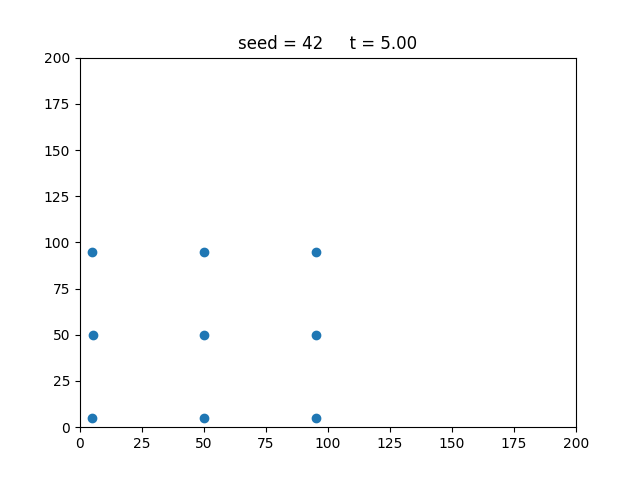

In [74]:
seed = 42
rng = default_rng(seed=seed) # instatiate the default random number generator
sqrtNumParts = 3

pPosGrid = list(itertools.product(np.linspace(5, 95,sqrtNumParts), np.linspace(5,95,sqrtNumParts)))
pVelGrid = list(rng.random(size=(sqrtNumParts**2,2))*0.1) #slightly randomize initial velocities

particles = [Disk(pPosGrid[i], pVelGrid[i]) for i in range(sqrtNumParts**2)]

e1 = Expt(particles, dt=0.05, tmax=5, animSpeed=1)

print(e1.avgKE)
e1.showAnimation("seed = " + str(seed) + "     ")
print(e1.avgKE)

In [75]:
plt.close("all")

In [ ]:
#create and test an example disk
p = Disk([1,1], [6,8], 3, 2, 1)
p1 = Disk([3, 2], [3, 3], 1, 1, 1)

print(p < p1)
print(p == p1)
print(p > p1)
print(p.speed)
print(p.KE)
print(p.x)
p.advance(2, 20)
print(p.speed)
print(p.KE)
print(p.x)
p.advance(1, 20)
print(p.speed)
print(p.KE)
print(p.x)